<a href="https://colab.research.google.com/github/dtabuena/Data_Explore/blob/main/Cluster_CA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [264]:
!pip install openpyxl
!pip install XlsxWriter
!pip install pingouin
from IPython.display import clear_output
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

clear_output()

In [265]:
plot_extras = True
exclude_extras =True

In [266]:
link = 'https://www.dropbox.com/sh/e52vk7qbr4p0pfw/AACSiEAskL4ZSexlFN0L5S76a?dl=0'
xl_to_analyze = 'CA3 parameters for PCA.xlsx'

my_drop_folder = 'my_drop_folder'
zipped_file_path = "/content/"+my_drop_folder + ".zip"
unzipped_file_path = "/content/"+my_drop_folder
if not( os.path.exists(zipped_file_path)):
    !wget -O $zipped_file_path $link    # download with new name
!echo A | unzip $zipped_file_path -d $unzipped_file_path 
print(unzipped_file_path)
my_df_dict  = pd.read_excel('my_drop_folder/'+xl_to_analyze, engine='openpyxl',index_col=0,sheet_name=None)
for k in my_df_dict.keys():
    print(k)

Archive:  /content/my_drop_folder.zip
mapname:  conversion of  failed
replace /content/my_drop_folder/CA1 main parameters.xlsx? [y]es, [n]o, [A]ll, [N]one, [r]ename:  extracting: /content/my_drop_folder/CA1 main parameters.xlsx  
 extracting: /content/my_drop_folder/CA3 parameters for PCA.xlsx  
 extracting: /content/my_drop_folder/DG Type I GC main parameters.xlsx  
 extracting: /content/my_drop_folder/DG Type II GC main parameters.xlsx  
/content/my_drop_folder
E4 9mo
E3 9mo
E4 19mo
E3 19mo
fE4 syncre+
fE4 syncre-


In [267]:
for k in my_df_dict.keys():
    df = my_df_dict[k]
    df['type'] = k
df_list = [my_df_dict[k] for k in my_df_dict.keys()]
full_df = pd.concat(df_list)

In [268]:
for r in full_df.index:
    if full_df.loc[r,'AP amp'] <60:
        full_df.at[r,'AP amp'] = np.nan

In [269]:
labeling = ['Cell','type','extra'] # non numerical data 
numericals = [c for c in full_df.columns if c not in labeling ]


full_df_norm = full_df.copy()
mean_dict = {}
sd_dict = {}

for c in full_df_norm.columns:
    if c not in labeling:
        col_mean = np.mean(full_df_norm[c])
        col_sd = np.std(full_df_norm[c])
        mean_dict[c] = col_mean
        sd_dict[c] = col_sd
        full_df_norm[c] = (full_df_norm[c] - col_mean)/col_sd


null_check = pd.isna(full_df_norm)
incomplete =[]
for r in full_df_norm.index:
    vals = np.array(null_check.loc[r,numericals])
    bad = any(vals)
    if bad:
        incomplete.append(r)
# print(incomplete)

complete = [c for c in  full_df_norm.index if c not in incomplete]
full_df_no_null = full_df_norm.loc[complete].copy()


if exclude_extras:
    is_extra = list(full_df_no_null['extra']==1)
    extra_ind = full_df_no_null.index[is_extra]
    full_df_no_null.drop( index =extra_ind, inplace=True)


data_X = full_df_no_null[numericals].to_numpy()
data_X.shape

display(full_df_no_null.head())
print('data_X.shape',data_X.shape)
data_for_fit = data_X
numericals = [n.replace('(1)', '') for n in numericals]

,Cm,Rin,RMP,I-F Gain,Rheobase,Spike Latency,Max Firing rate,AP threshold,fAHP(1),sAHP,AP width,AP amp,Adaptation Ratio,AP rise time,extra,type
20200305-01,-1.104259,2.264200,0.394578,0.438485,-1.227478,-1.790853,0.235614,-0.835380,0.103238,-0.968985,2.596801,1.819227,-0.113208,0.820563,0.0,E4 9mo
20200305-06,-0.667117,2.259204,-1.054464,0.748138,-1.227478,-1.430757,-0.253616,-0.740452,-0.186964,-0.835297,2.694438,1.561523,-0.281009,0.701092,0.0,E4 9mo
20200305-11,-1.650687,1.348011,-1.035645,1.367446,-0.852415,-0.867714,0.154076,-0.605151,0.193991,-0.402368,-0.168654,0.180924,-0.094036,-0.135436,0.0,E4 9mo
20200305-17,-0.651089,0.349899,0.902684,-0.114468,1.022898,1.075167,-0.416693,1.726084,2.300637,1.094688,-0.405647,-0.705788,-0.438359,0.013748,0.0,E4 9mo
20200305-22,-0.696503,1.220578,-0.696908,0.173067,-0.627377,-0.533827,0.235614,1.074537,0.938500,-0.190335,0.044507,-0.498479,-0.364346,-0.091224,0.0,E4 9mo


data_X.shape (136, 14)


In [270]:


type_list = list(full_df_no_null['type'])
uniq_types = list(set(type_list))
uniq_types.sort()
print(uniq_types)
num_t = len(uniq_types)
type_num = [ uniq_types.index(t) for t in type_list]

colors = plt.cm.viridis(np.linspace(0,1,num_t))
alpha = .2
colors = [[0, 0, 0, 1], [0, 0, 0, alpha],
          [1, 0, 1, 1], [1, 0, 1, alpha], 
          [0, .8, .8, 1], [0, .8, .8, alpha]]

alpha = .5
colors = [[0, 0, 1, 1], [0, 0, 1, alpha],
          [1, 0, 0, 1], [1, 0, 0, alpha], 
          [0, 0.5, 0, 1], [0, 0.5, 0, alpha]]

list_colors = [colors[i] for i in type_num ]

fig_opt = {'dpi': 300, 'format':'png','bbox_inches':'tight'}

['E3 19mo', 'E3 9mo', 'E4 19mo', 'E4 9mo', 'fE4 syncre+', 'fE4 syncre-']


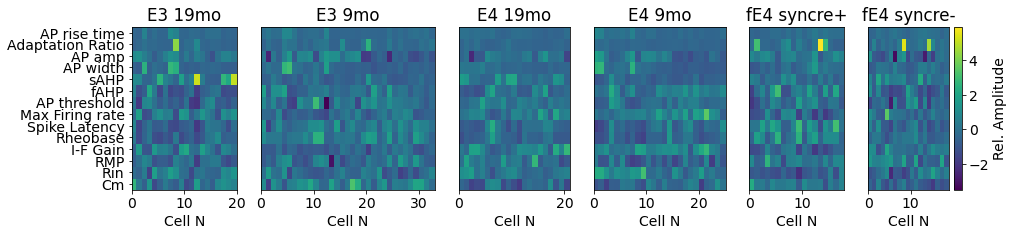

In [271]:
### raw_data_map 
counts = [np.sum( [tt==t for tt in type_list]) for t in uniq_types ]
fig, ax = plt.subplots(1,num_t,figsize = [15,3],gridspec_kw={'width_ratios': counts})


data_X_min = np.min(data_for_fit)
data_X_max = np.max(data_for_fit)

for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]

    c = ax[ti].pcolor(data_for_fit.T[:,is_type], vmin=data_X_min, vmax=data_X_max)
    ax[ti].set_yticks(np.arange(len(numericals))+0.5)
    if ti ==0 : ax[ti].set_yticklabels(numericals,rotation=0)
    else:  ax[ti].get_yaxis().set_visible(False)
    ax[ti].set_xlabel('Cell N')
    ax[ti].title.set_text(t)

    start = min(is_type)+3 / len(is_type)
    stop = max(is_type)-3 / len(is_type)

    
plt.colorbar(c, ax=ax[ti],label='Rel. Amplitude')
plt.show()
fig.savefig('Normalized_Vals_split.'+fig_opt['format'],**fig_opt)

plt.rcParams.update({'font.size': 10})

/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.7/dist-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


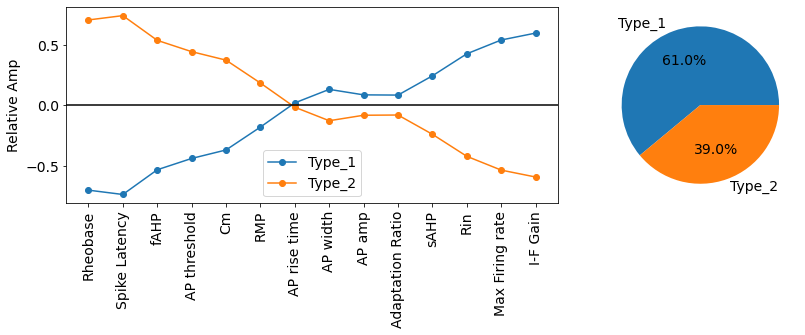

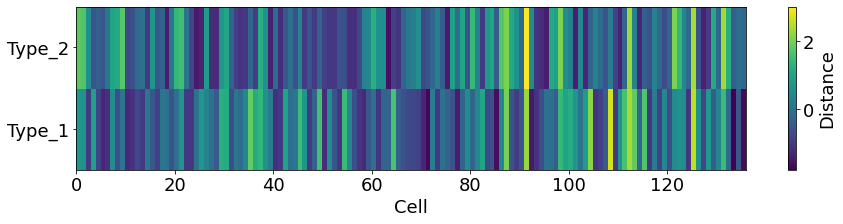

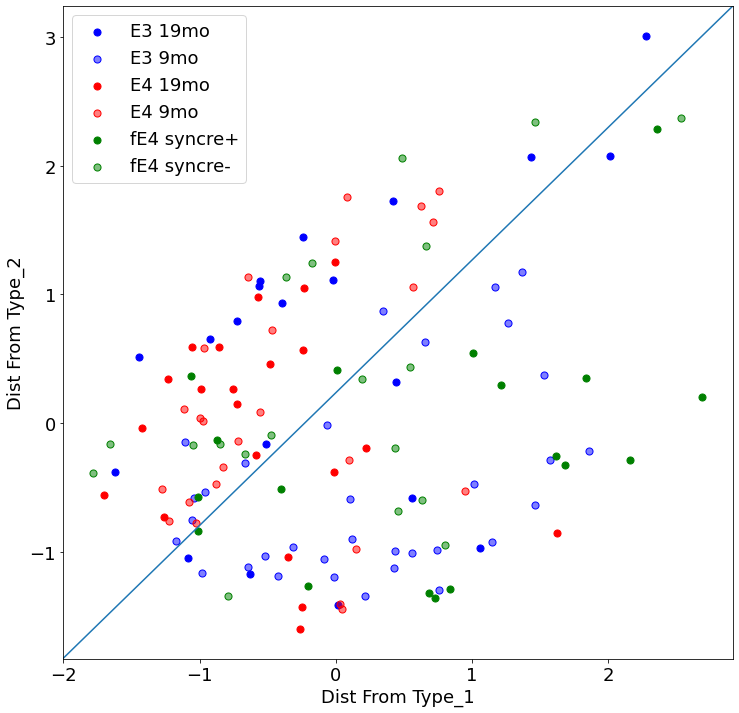

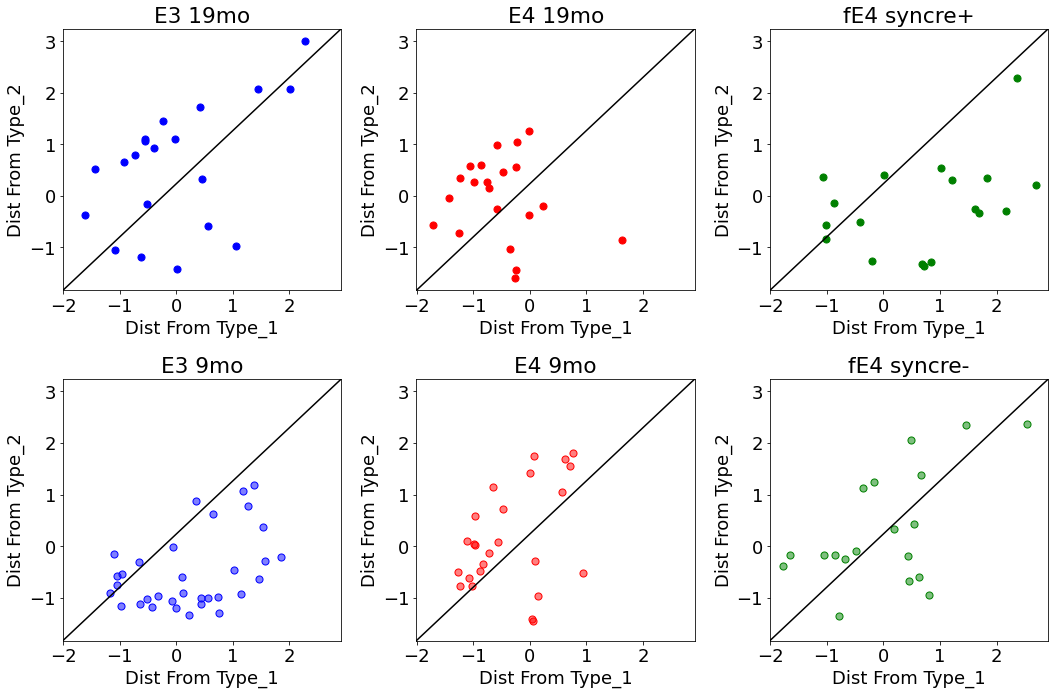

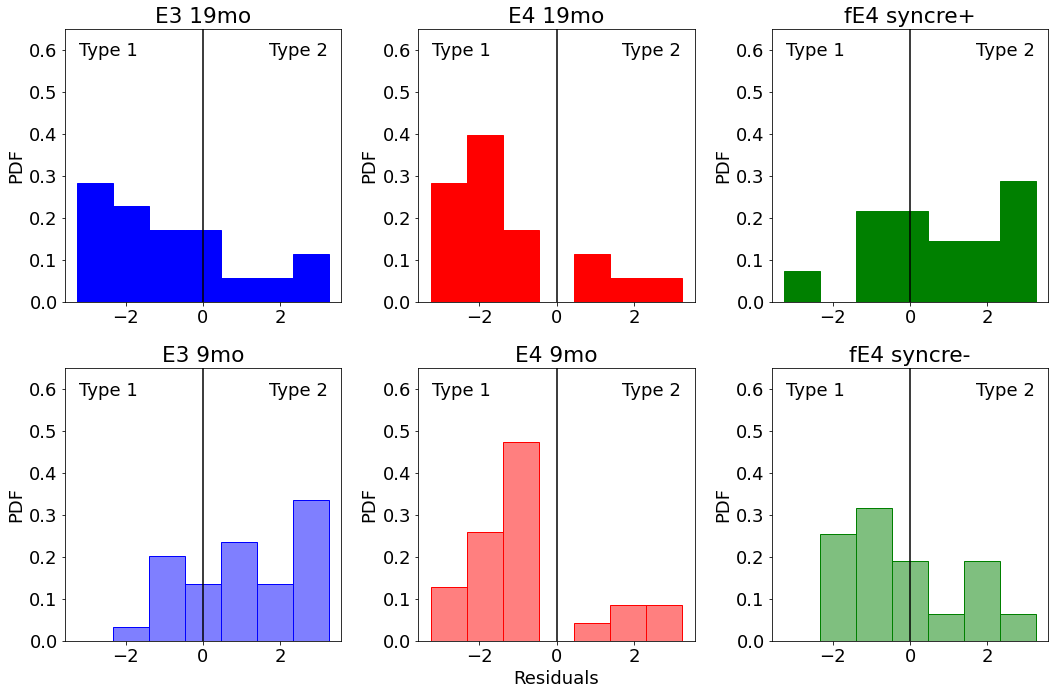

In [277]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42).fit(data_for_fit)
centers = kmeans.cluster_centers_.T
distances = kmeans.transform(data_for_fit)

rel_centers = (centers.T - np.mean(centers.T,axis = 0)).T

new_cent_order = np.argsort(centers[:,0]).tolist()
fig_clust_pie, ax = plt.subplots(1,2,figsize = [12,5], gridspec_kw={'width_ratios': [2, 1]} )
ax[0].plot(rel_centers[new_cent_order,:],'-o')
ax[0].legend(['Type_1', 'Type_2'])
sorted_numericals = [numericals[i] for i in new_cent_order]
ax[0].set_xticks(np.arange(len(numericals)))
ax[0].set_xticklabels(sorted_numericals,rotation=90)
ax[0].set_ylabel('Relative Amp')
ax[0].axhline(0,color='k')
labels = kmeans.labels_ 
rel_counts = [np.mean( l == labels ) for l in range(2)]
# print(counts)
ax[1].pie( rel_counts, labels=['Type_1 ', 'Type_2 '],autopct='%1.1f%%' )
plt.rcParams.update({'font.size': 18})
plt.tight_layout()


total_D = np.tile(np.sum(distances,axis=1),[2,1]).T
closeness = np.log(total_D/distances)
closeness = (closeness - np.mean(closeness,axis=0)) / (np.std(closeness,axis=0))  
distances_norm = (distances - np.mean(distances,axis=0)) / (np.std(distances,axis=0))

fig_distances, ax = plt.subplots(1,figsize = [15,3])
c = ax.pcolor(distances_norm.T)
ax.set_xlabel('Cell')
ax.set_yticks(np.arange(2)+0.5)
ax.set_yticklabels(['Type_1', 'Type_2'])
# ax.title.set_text('Distance')
fig_distances.colorbar(c, ax=ax,label='Distance')
fig_distances.savefig('Cells_in_Clusters.'+fig_opt['format'],**fig_opt)

fig_comb_scatter, ax = plt.subplots(1,figsize = [12,12])
for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]    
    t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
    ax.scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=50)
ax.legend()
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xlabel('Dist From Type_1')
ax.set_ylabel('Dist From Type_2')
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
comb_xlim = ax.get_xlim()
comb_ylim = ax.get_ylim()

#### separate #####
fig_sep_scatter, axs = plt.subplots(2,3,figsize = [15,10])
axs = axs.T.flatten()
for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]
    t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]
    axs[ti].scatter(distances_norm[is_type,0],distances_norm[is_type,1],color=t_colr, label=t,linewidths=1,edgecolors=t_colr_edge,s=50)
    axs[ti].set_xlabel('Dist From Type_1')
    axs[ti].set_ylabel('Dist From Type_2')
    axs[ti].plot([0, 1], [0, 1], transform=axs[ti].transAxes,color=[0,0,0,1])
    axs[ti].title.set_text(t)
    axs[ti].set_xlim(comb_xlim)
    axs[ti].set_ylim(comb_ylim)

    if plot_extras:
        is_extra = list(full_df_no_null['extra']==1)
        is_extra_ind = [i for i in range(len(is_extra)) if is_extra[i] ]
        both = [i for i in is_type if i in is_extra_ind]
        axs[ti].scatter(distances_norm[both,0],distances_norm[both,1],color=t_colr,
                         label=t,marker='x',s=400,linewidths=3,edgecolors=t_colr_edge)
plt.rcParams.update({'font.size': 18})
plt.tight_layout()





#### separate #####
fig_sep_hist, axs = plt.subplots(2,3,figsize = [15,10])
axs = axs.T.flatten()
for ti in range(num_t):
    t = uniq_types[ti]
    t_colr = colors[ti]
    t_colr_edge = colors[  int(np.ceil((ti+1)/2)-1)*2 ]
    is_type = [ind for ind in range(len(type_num)) if type_num[ind]==ti]

    score = closeness[:,1] - closeness[:,0]

    axs[ti].hist(score[is_type],7,color=t_colr,histtype='bar',density=True,range=(-3.25,3.25),edgecolor=t_colr_edge)
    axs[ti].title.set_text(t)
    axs[ti].axvline(0, color='k') # vertical
    axs[ti].set_ylim(0,0.65)
    axs[ti].set_ylabel('PDF')
    axs[ti].text(.95, .9, 'Type 2',transform=axs[ti].transAxes,ha='right')
    axs[ti].text(.05, .9, 'Type 1',transform=axs[ti].transAxes,ha='left')

    if plot_extras:
        is_extra = list(full_df_no_null['extra']==1)
        is_extra_ind = [i for i in range(len(is_extra)) if is_extra[i] ]
        both = [i for i in is_type if i in is_extra_ind]
        axs[ti].hist(score[both],10,color=t_colr,histtype='step',density=True,range=(-3.25,3.25))

axs[3].set_xlabel('Residuals')


plt.rcParams.update({'font.size': 18})
plt.tight_layout()
plt.show()

fig_clust_pie.savefig('Clusters.'+fig_opt['format'],**fig_opt)
fig_sep_scatter.savefig('GenoType_dist_Separate.'+fig_opt['format'],**fig_opt)
fig_comb_scatter.savefig('GenoType_dist.'+fig_opt['format'],**fig_opt)
fig_sep_hist.savefig('GenoType_Histos.'+fig_opt['format'],**fig_opt)

In [284]:
is_E3 = ['E3' in t for t in type_list ]
is_9mo = [' 9' in t for t in type_list ]
age_list = [9 if b else 19 for b in is_9mo]
genotype = ['E3' if b else 'E4' for b in is_E3]
is_crePos = ['cre+' in t for t in type_list ]
is_creNeg = ['cre-' in t for t in type_list ]
not_cree = [not any( [is_crePos[i], is_creNeg[i]] ) for i in range(len(is_crePos))]
e34_genotype = [genotype[i] for i in range(len(not_cree)) if not_cree[i]]
e34_score = [score[i] for i in range(len(not_cree)) if not_cree[i]]
e34_age = [str(age_list[i])+'mo' for i in range(len(not_cree)) if not_cree[i]]
genotype_list_str = [t.replace(' 9mo', '').replace(' 19mo', '') for t in type_list]
age_list_str = [str(a)+'mo' for a in age_list]


df_for_34_2W_anova =  pd.DataFrame({'genotype': genotype_list_str,  'Age': age_list_str,'T1_Score': score})

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import pingouin as pg
ANOVA2_results = pg.anova(dv='T1_Score', between=['genotype', 'Age'], data=df_for_34_2W_anova, detailed=True)
display(ANOVA2_results)
ANOVA2_results.to_csv('2W_results Age-Geno.csv')

df_for_34_2W_anova['combination'] = df_for_34_2W_anova.genotype + " : " + df_for_34_2W_anova.Age
m_comp = pairwise_tukeyhsd(endog=df_for_34_2W_anova['T1_Score'], groups=df_for_34_2W_anova['combination'], alpha=0.05)
tukey_data = pd.DataFrame(data=m_comp._results_table.data[1:], columns = m_comp._results_table.data[0])
tukey_data = tukey_data.sort_values('p-adj',ascending=True)
display(tukey_data)
tukey_data.to_csv('pairwise Age-Genotype.csv')

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1873: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)


,Source,SS,DF,MS,F,p-unc,np2
0,genotype,55.855029,3.0,18.618343,5.792498,0.003892,0.117911
1,Age,8.332468,1.0,8.332468,2.592379,0.109805,0.019551
2,genotype * Age,76.860646,3.0,25.620215,7.970905,0.000064,0.155365
3,Residual,417.848189,130.0,3.214217,NaN,NaN,NaN


,group1,group2,meandiff,p-adj,lower,upper,reject
5,E3 : 9mo,E4 : 19mo,-2.0433,0.0011,-3.4910,-0.5956,True
6,E3 : 9mo,E4 : 9mo,-1.9215,0.0012,-3.2966,-0.5464,True
0,E3 : 19mo,E3 : 9mo,2.0223,0.0016,0.5527,3.4920,True
10,E4 : 19mo,fE4 syncre+ : 19mo,2.0437,0.0070,0.3779,3.7095,True
3,E3 : 19mo,fE4 syncre+ : 19mo,2.0227,0.0090,0.3378,3.7076,True
12,E4 : 9mo,fE4 syncre+ : 19mo,1.9219,0.0091,0.3188,3.5250,True
8,E3 : 9mo,fE4 syncre- : 19mo,-1.7333,0.0130,-3.2268,-0.2398,True
14,fE4 syncre+ : 19mo,fE4 syncre- : 19mo,-1.7337,0.0440,-3.4395,-0.0279,True
11,E4 : 19mo,fE4 syncre- : 19mo,0.3100,0.9941,-1.3320,1.9521,False
4,E3 : 19mo,fE4 syncre- : 19mo,0.2891,0.9960,-1.3724,1.9505,False


100%|██████████| 1000/1000 [02:14<00:00,  7.41it/s]


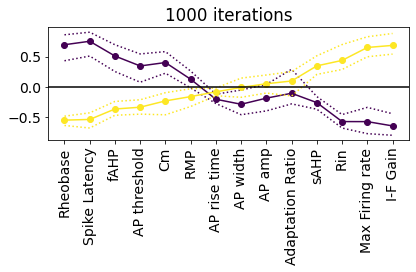

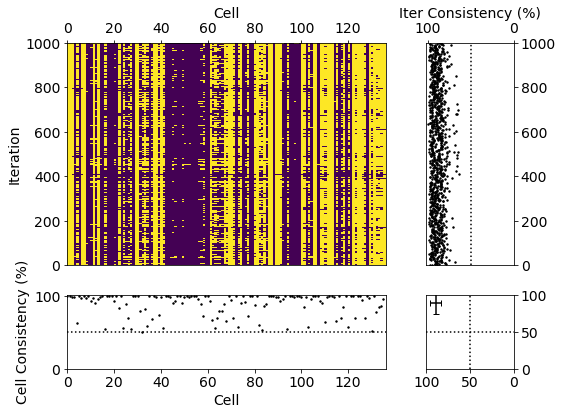

In [274]:
from pandas.compat.numpy import np_array_datetime64_compat
###########   Cluster Validation #############
from random import sample
from tqdm import tqdm
import scipy
''' random sub sample cluster and plot cluster center similarity '''
SubSampleFrac = .8
num_iter = 1000
center_list = []
label_list = []
sub_sample_ind_list = []
full_label_list = []
k = 2
plt.rcParams.update({'font.size': 14})
pred_all = True

for ni in tqdm( range(num_iter) ):
    sub_sample_ind = []
    for t in uniq_types:
        t_inds = [i for i in range(len(type_list)) if t in type_list[i]]
        # print(t_inds)
        sub_sample_ind.extend( sample(t_inds, int(len(t_inds)*SubSampleFrac) ) )
    kmeans_iter = KMeans(n_clusters=k, random_state=42).fit(data_for_fit[sub_sample_ind][:,new_cent_order])
    centers_iter = kmeans_iter.cluster_centers_.T
    centers_iter = centers_iter - np.mean(centers_iter,axis=0)
    labels_iter = kmeans_iter.labels_
    if pred_all:
        labels_iter = kmeans_iter.predict(data_for_fit)

    if ni>0:
        corco = np.corrcoef(centers_iter.T,center_list[0].T)
        corco = corco[0:k,k:]
        ind = np.argmax(corco,axis=0) 
        centers_iter = centers_iter[:,ind]
        labels_iter = [ind[l] for l in labels_iter]
    
    if not pred_all:
        full_label_iter = np.empty((data_for_fit.shape[0],))
        full_label_iter[:] = np.nan
        full_label_iter[sub_sample_ind] = labels_iter
    else:
        full_label_iter = labels_iter

    center_list.append(centers_iter)
    label_list.append(labels_iter)
    sub_sample_ind_list.append(sub_sample_ind_list)
    full_label_list.append(full_label_iter)
   
center_stack = np.stack(center_list)
mean_center = np.mean(center_stack,0)
nintey_p_center = np.percentile(center_stack, [2.5, 97.5], axis=0)

cmap = plt.cm.viridis(np.linspace(0,1,k))
fig_cv_cent, ax = plt.subplots(1)
for ki in range(k):
    ax.plot(mean_center[:,ki].T,'-o',color=cmap[ki])
    ax.plot(nintey_p_center[0,:,ki].T,':',color=cmap[ki])
    ax.plot(nintey_p_center[1,:,ki].T,':',color=cmap[ki])


ax.set_xticks(np.arange(len(numericals)))
ax.set_xticklabels(sorted_numericals,rotation=90)
ax.axhline(0, color='k')



full_label_stack = np.stack(full_label_list)

pseudo_truth = scipy.stats.mode(full_label_stack,axis=0, nan_policy='omit')[0]
is_match = (full_label_stack == pseudo_truth)*1. # convert to float so can accept nans
is_match[np.isnan(full_label_stack)]=np.nan
consistency_iter = np.nanmean(is_match, axis = 1)
mean_consistency_iter = np.nanmean(consistency_iter)
std_consistency_iter = np.nanstd(consistency_iter)
consistency_cell = np.nanmean(is_match, axis = 0)
mean_consistency_cell = np.nanmean(consistency_cell)
sd_consistency_cell = np.nanstd(consistency_cell)
consistency_report = 'label consistency: ' + str(round(mean_consistency_cell*100,1)) + '% +- ' + str(round(sd_consistency_cell*100,2)) + ' (chance: ' + str(round(1/k*100,1))+')'
# print(consistency_report)
# print('(chance: ' + str(round(1/k*100,1))+')')
ax.title.set_text( str(ni+1) +' iterations' )

# plt.rcParams.update({'font.size': 18})
plt.tight_layout()
plt.show()
fig_cv_cent.savefig(f'CrossVal_Data k={k} Centers.'+fig_opt['format'],**fig_opt)

fig_cv_prob, ax = plt.subplots(2,2,figsize=[8,6], gridspec_kw={'height_ratios': [3, 1],'width_ratios': [4, 1.1]}  )
ax  = ax.T.flatten()
ax[0].pcolor( full_label_stack )
ax[0].set_xlabel('Cell')
ax[0].set_ylabel('Iteration')
ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.tick_top()

ax[1].scatter(np.arange(len(consistency_cell)),consistency_cell*100,color='k',s=2)
ax[1].axhline(1/k*100,color='k',linestyle=':')
ax[1].set_ylabel('Cell Consistency (%)')
ax[1].set_ylim((0,102))
ax[1].set_xlim((0,is_match.shape[1]))
ax[1].set_xlabel('Cell')


ax[2].scatter(consistency_iter*100,np.arange(num_iter),color='k',s=2)
ax[2].axvline(1/k*100,color='k',linestyle=':')
ax[2].set_xlabel('Iter Consistency (%)')
ax[2].set_xlim((102,0))
ax[2].set_ylim((0,num_iter))
ax[2].yaxis.tick_right()
ax[2].xaxis.set_label_position('top') 
ax[2].xaxis.tick_top()

# fig.delaxes(ax[3])
ax[3].errorbar(mean_consistency_iter*100, mean_consistency_cell*100, yerr=sd_consistency_cell*100, xerr=std_consistency_iter*100,color='k',capsize=3)
ax[3].axvline(1/k*100,color='k',linestyle=':')
ax[3].axhline(1/k*100,color='k',linestyle=':')
ax[3].set_xlim((100,0))
ax[3].set_ylim((0,100))
ax[3].yaxis.tick_right()

# plt.rcParams.update({'font.size': 18})
# 
# plt.show()
# plt.tight_layout()
fig_cv_prob.savefig(f'CrossVal_Data k={k} Labeling.'+fig_opt['format'],**fig_opt)

100%|██████████| 1000/1000 [02:39<00:00,  6.25it/s]


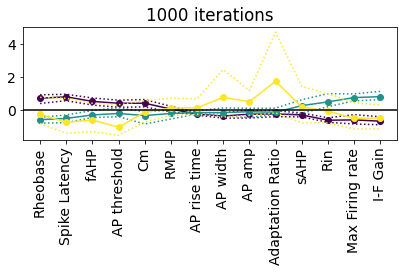

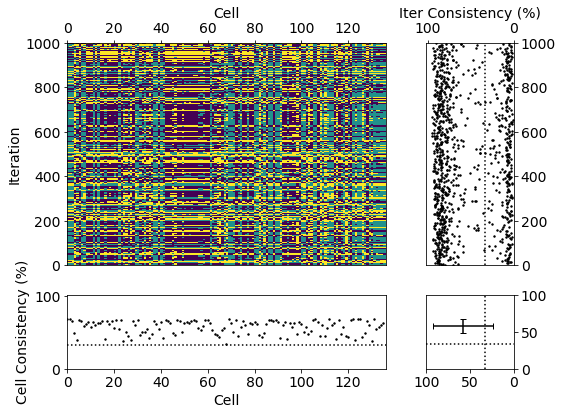

In [278]:
from pandas.compat.numpy import np_array_datetime64_compat
###########   Cluster Validation #############
from random import sample
from tqdm import tqdm
import scipy
''' random sub sample cluster and plot cluster center similarity '''
SubSampleFrac = .8
num_iter = 1000
center_list = []
label_list = []
sub_sample_ind_list = []
full_label_list = []
k = 3
plt.rcParams.update({'font.size': 14})
pred_all = True

for ni in tqdm( range(num_iter) ):
    sub_sample_ind = []
    for t in uniq_types:
        t_inds = [i for i in range(len(type_list)) if t in type_list[i]]
        # print(t_inds)
        sub_sample_ind.extend( sample(t_inds, int(len(t_inds)*SubSampleFrac) ) )
    kmeans_iter = KMeans(n_clusters=k, random_state=42).fit(data_for_fit[sub_sample_ind][:,new_cent_order])
    centers_iter = kmeans_iter.cluster_centers_.T
    centers_iter = centers_iter - np.mean(centers_iter,axis=0)
    labels_iter = kmeans_iter.labels_
    if pred_all:
        labels_iter = kmeans_iter.predict(data_for_fit)

    if ni>0:
        corco = np.corrcoef(centers_iter.T,center_list[0].T)
        corco = corco[0:k,k:]
        ind = np.argmax(corco,axis=0) 
        centers_iter = centers_iter[:,ind]
        labels_iter = [ind[l] for l in labels_iter]
    
    if not pred_all:
        full_label_iter = np.empty((data_for_fit.shape[0],))
        full_label_iter[:] = np.nan
        full_label_iter[sub_sample_ind] = labels_iter
    else:
        full_label_iter = labels_iter

    center_list.append(centers_iter)
    label_list.append(labels_iter)
    sub_sample_ind_list.append(sub_sample_ind_list)
    full_label_list.append(full_label_iter)
   
center_stack = np.stack(center_list)
mean_center = np.mean(center_stack,0)
nintey_p_center = np.percentile(center_stack, [2.5, 97.5], axis=0)

cmap = plt.cm.viridis(np.linspace(0,1,k))
fig_cv_cent, ax = plt.subplots(1)
for ki in range(k):
    ax.plot(mean_center[:,ki].T,'-o',color=cmap[ki])
    ax.plot(nintey_p_center[0,:,ki].T,':',color=cmap[ki])
    ax.plot(nintey_p_center[1,:,ki].T,':',color=cmap[ki])


ax.set_xticks(np.arange(len(numericals)))
ax.set_xticklabels(sorted_numericals,rotation=90)
ax.axhline(0, color='k')



full_label_stack = np.stack(full_label_list)

pseudo_truth = scipy.stats.mode(full_label_stack,axis=0, nan_policy='omit')[0]
is_match = (full_label_stack == pseudo_truth)*1. # convert to float so can accept nans
is_match[np.isnan(full_label_stack)]=np.nan
consistency_iter = np.nanmean(is_match, axis = 1)
mean_consistency_iter = np.nanmean(consistency_iter)
std_consistency_iter = np.nanstd(consistency_iter)
consistency_cell = np.nanmean(is_match, axis = 0)
mean_consistency_cell = np.nanmean(consistency_cell)
sd_consistency_cell = np.nanstd(consistency_cell)
consistency_report = 'label consistency: ' + str(round(mean_consistency_cell*100,1)) + '% +- ' + str(round(sd_consistency_cell*100,2)) + ' (chance: ' + str(round(1/k*100,1))+')'
# print(consistency_report)
# print('(chance: ' + str(round(1/k*100,1))+')')
ax.title.set_text( str(ni+1) +' iterations' )

# plt.rcParams.update({'font.size': 18})
plt.tight_layout()
plt.show()
fig_cv_cent.savefig(f'CrossVal_Data k={k} Centers.'+fig_opt['format'],**fig_opt)

fig_cv_prob, ax = plt.subplots(2,2,figsize=[8,6], gridspec_kw={'height_ratios': [3, 1],'width_ratios': [4, 1.1]}  )
ax  = ax.T.flatten()
ax[0].pcolor( full_label_stack )
ax[0].set_xlabel('Cell')
ax[0].set_ylabel('Iteration')
ax[0].xaxis.set_label_position('top') 
ax[0].xaxis.tick_top()

ax[1].scatter(np.arange(len(consistency_cell)),consistency_cell*100,color='k',s=2)
ax[1].axhline(1/k*100,color='k',linestyle=':')
ax[1].set_ylabel('Cell Consistency (%)')
ax[1].set_ylim((0,102))
ax[1].set_xlim((0,is_match.shape[1]))
ax[1].set_xlabel('Cell')


ax[2].scatter(consistency_iter*100,np.arange(num_iter),color='k',s=2)
ax[2].axvline(1/k*100,color='k',linestyle=':')
ax[2].set_xlabel('Iter Consistency (%)')
ax[2].set_xlim((102,0))
ax[2].set_ylim((0,num_iter))
ax[2].yaxis.tick_right()
ax[2].xaxis.set_label_position('top') 
ax[2].xaxis.tick_top()

# fig.delaxes(ax[3])
ax[3].errorbar(mean_consistency_iter*100, mean_consistency_cell*100, yerr=sd_consistency_cell*100, xerr=std_consistency_iter*100,color='k',capsize=3)
ax[3].axvline(1/k*100,color='k',linestyle=':')
ax[3].axhline(1/k*100,color='k',linestyle=':')
ax[3].set_xlim((100,0))
ax[3].set_ylim((0,100))
ax[3].yaxis.tick_right()

# plt.rcParams.update({'font.size': 18})
# 
# plt.show()
# plt.tight_layout()
fig_cv_prob.savefig(f'CrossVal_Data k={k} Labeling.'+fig_opt['format'],**fig_opt)

In [288]:
root_list = []
f_list = []
import os
import shutil
try: shutil.rmtree("/content/Results")
except: None
try: os.mkdir("/content/Results")
except: None
try: os.remove("Results.zip")
except: None
    
from google import colab
for root, dirs, files in os.walk("/content"):
    for f in files:
        if 'sample_data' in root: continue
        if 'Results' in root: continue
        if f.endswith(".png"):
            shutil.copyfile(os.path.join(root,f), os.path.join(root,'Results',f))
        if f.endswith(".csv"):
            shutil.copyfile(os.path.join(root,f), os.path.join(root,'Results',f))

!zip -r Results.zip Results
colab.files.download("Results.zip")

  adding: Results/ (stored 0%)
  adding: Results/pairwise Age-Genotype.csv (deflated 62%)
  adding: Results/CrossVal_Data k=3 Labeling.png (deflated 7%)
  adding: Results/CrossVal_Data k=2 Labeling.png (deflated 11%)
  adding: Results/2W_results Age-Geno.csv (deflated 39%)
  adding: Results/Cells_in_Clusters.png (deflated 26%)
  adding: Results/GenoType_Histos.png (deflated 32%)
  adding: Results/Clusters.png (deflated 10%)
  adding: Results/CrossVal_Data k=2 Centers.png (deflated 7%)
  adding: Results/GenoType_dist_Separate.png (deflated 18%)
  adding: Results/Normalized_Vals_split.png (deflated 18%)
  adding: Results/CrossVal_Data k=3 Centers.png (deflated 7%)
  adding: Results/GenoType_dist.png (deflated 13%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [293]:
##### Importance Test
num_rep = 10
scram = data_for_fit.copy()
# for ni in range(len(numericasl)):
#     n = numericals[ni]
#     for rep in range(num_rep):
#         scram = data_for_fit.copy()
        
#         kmeans.predict()
